In this notebook we implement a multi-output pinn using forward mode autodiff.

In [1]:
# %% Imports
import jax
from jax.ops import index, index_update
from jax import random, numpy as jnp
from flax import optim, linen as nn
from code import MLP, train_step, burgers, mse_loss, MultiTaskMLP

from time import time
from typing import Sequence
from functools import partial

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%config InlineBackend.figure_format = 'svg'
%load_ext autoreload
%autoreload 2

Let's use the same dataset 10 times:

In [2]:
# Making dataset
n_out = 10
x = jnp.linspace(-3, 4, 100)
t = jnp.linspace(0.5, 5.0, 20)

t_grid, x_grid = jnp.meshgrid(t, x, indexing='ij')
u = burgers(x_grid, t_grid, 0.1, 1.0)

X_train = jnp.concatenate([t_grid.reshape(-1, 1), x_grid.reshape(-1, 1)], axis=1)
y_train = jnp.ones((X_train.shape[0], n_out)) *  u.reshape(-1, 1)

In [3]:
print(X_train.shape, y_train.shape)

(2000, 2) (2000, 10)


Let's first train a model before constructing the library

In [4]:
# Instantiating model and optimizers
model = MLP(features=[50, 50, n_out])
key = random.PRNGKey(42)
params = model.init(key, X_train[[0], :])
optimizer = optim.Adam(learning_rate=2e-3, beta1=0.99, beta2=0.99)
optimizer = optimizer.create(params)

In [5]:
%%time
# Compiling train step
step = train_step(model, X_train, y_train)
_ = step(optimizer)  # triggering compilation

CPU times: user 617 ms, sys: 107 ms, total: 725 ms
Wall time: 1.07 s


In [6]:
%%time
# Running to convergence
max_epochs = 10001
for i in jnp.arange(max_epochs):
    optimizer, loss = step(optimizer)
    if i % 1000 == 0:
        print(f"Loss step {i}: {loss}")

Loss step 0: 2.3597700595855713
Loss step 1000: 0.0004099361540284008
Loss step 2000: 1.499641984992195e-05
Loss step 3000: 5.344761120795738e-06
Loss step 4000: 4.057548267155653e-06
Loss step 5000: 2.7383853193896357e-06
Loss step 6000: 1.4086521105127758e-06
Loss step 7000: 1.3671153737959685e-06
Loss step 8000: 2.275854058098048e-06
Loss step 9000: 1.7431326568839722e-06
Loss step 10000: 1.0210671916865977e-06
CPU times: user 4.24 s, sys: 242 ms, total: 4.48 s
Wall time: 4.19 s


In [7]:
f = partial(model.apply, optimizer.target)
x = X_train
n_samples = X_train.shape[0]

In [8]:
%%time
jacobian = jax.jacfwd(f)(x)[jnp.arange(n_samples), :, jnp.arange(n_samples), :]

CPU times: user 1.29 s, sys: 149 ms, total: 1.44 s
Wall time: 2.04 s


In [9]:
def vgrad_forward(f, x, input_idx):
    s = index_update(jnp.zeros_like(x), index[:, input_idx], 1)
    _, jvp = jax.jvp(f, (x, ), (s, ))
    return jvp

In [10]:
# Getting derivatives
df = partial(vgrad_forward, f, input_idx=1)
d2f = partial(vgrad_forward, df, input_idx=1)
d3f = partial(vgrad_forward, d2f, input_idx=1)

pred = jnp.expand_dims(f(x).T, axis=-1)
dt = jnp.expand_dims(vgrad_forward(f, X_train, input_idx=0).T, axis=-1)

In [11]:
pred.shape

(10, 2000, 1)

In [12]:
# Polynomials: 1st axis is experiment, 2nd sample, 3rd dimension
u = jnp.concatenate([jnp.ones_like(pred), pred, pred**2], axis=-1)

In [13]:
u.shape

(10, 2000, 3)

In [14]:
du = jnp.concatenate([jnp.ones_like(pred), jnp.expand_dims(df(x).T, axis=-1), 
                      jnp.expand_dims(d2f(x).T, axis=-1),
                      jnp.expand_dims(d3f(x).T, axis=-1)], axis=-1)

In [15]:
du.shape

(10, 2000, 4)

In [16]:
theta = (jnp.expand_dims(u, axis=-1) @ jnp.expand_dims(du, axis=-2)).reshape(*pred.shape[:2], -1)

In [17]:
theta.shape

(10, 2000, 12)

In [18]:
dt.shape

(10, 2000, 1)

In [19]:
pred.shape

(10, 2000, 1)

Nice, lets code it up in a nice function:

In [7]:
def library(f, x):
    # First derivs
    df = partial(vgrad_forward, f, input_idx=1)
    d2f = partial(vgrad_forward, df, input_idx=1)
    d3f = partial(vgrad_forward, d2f, input_idx=1)

    pred = jnp.expand_dims(f(x).T, axis=-1)
    dt = jnp.expand_dims(vgrad_forward(f, X_train, input_idx=0).T, axis=-1)

    # Polynomials: 1st axis is experiment, 2nd sample, 3rd dimension
    u = jnp.concatenate([jnp.ones_like(pred), pred, pred**2], axis=-1)
    du = jnp.concatenate([jnp.ones_like(pred), jnp.expand_dims(df(x).T, axis=-1), 
                              jnp.expand_dims(d2f(x).T, axis=-1),
                              jnp.expand_dims(d3f(x).T, axis=-1)], axis=-1)
    theta = (jnp.expand_dims(u, axis=-1) @ jnp.expand_dims(du, axis=-2)).reshape(*pred.shape[:2], -1)
    
    return pred.squeeze().T, dt, theta

In [21]:
prediction, dt, theta = library(f, x)

Normal numpy won't work over all coeffs, so lets use vmap to vectorize over it :)

<AxesSubplot:>

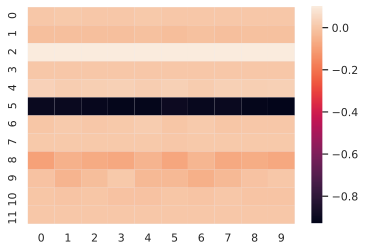

In [22]:
prediction, dt, theta = library(f, x)
fit = lambda X, y: jnp.linalg.lstsq(X, y)[0]
coeffs = jax.vmap(fit, in_axes=(0, 0), out_axes=0)(theta, dt)
sns.heatmap(coeffs.T.squeeze())

In [23]:
coeffs.shape

(10, 12, 1)

<AxesSubplot:>

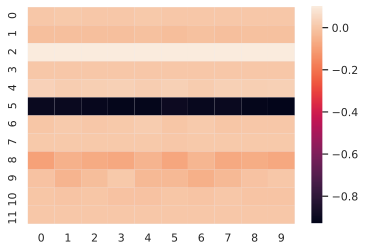

In [24]:
sns.heatmap(coeffs.T.squeeze())

In [25]:
(dt - theta @ coeffs).shape

(10, 2000, 1)

In [26]:
prediction.shape

(2000, 10)

In [27]:
y_train.shape

(2000, 10)

In [28]:
mse_loss(prediction, y_train) 

DeviceArray(1.5582934e-06, dtype=float32)

In [29]:
mse_loss(dt.squeeze(), (theta @ coeffs).squeeze())

DeviceArray(0.0193143, dtype=float32)

Holy cow it works. Lets code it up nicely and test speed:

In [30]:
def train_step_pinn(model, library, x, y):
    """Constructs a fast update given a loss function.
    """
    def step(opt, x, y, model, library):
        def loss_fn(params, x, y, model, library):
            prediction, dt, theta = library(partial(model.apply, params), x)
            
            fit = lambda X, y: jnp.linalg.lstsq(X, y)[0]
            coeffs = jax.vmap(fit, in_axes=(0, 0), out_axes=0)(theta, dt) #vmap over experiments
            
            loss = mse_loss(prediction, y) + mse_loss(dt.squeeze(), (theta @ coeffs).squeeze())
            return loss

        grad_fn = jax.value_and_grad(loss_fn, argnums=0)
        loss, grad = grad_fn(opt.target, x, y, model, library)
        opt = opt.apply_gradient(grad)  # Return the updated optimizer with parameters.
        return opt, loss
    return jax.jit(partial(step, x=x, y=y, model=model, library=library))

In [31]:
# Instantiating model and optimizers
model = MLP(features=[50, 50, n_out])
key = random.PRNGKey(42)
params = model.init(key, X_train[[0], :])
optimizer = optim.Adam(learning_rate=2e-3, beta1=0.99, beta2=0.99)
optimizer = optimizer.create(params)

In [32]:
%%time
# Compiling train step
step = train_step_pinn(model, library, X_train, y_train)
_ = step(optimizer)  # triggering compilation

CPU times: user 1.54 s, sys: 15 ms, total: 1.56 s
Wall time: 1.83 s


In [33]:
%%time
# Running to convergence
max_epochs = 10001
for i in jnp.arange(max_epochs):
    optimizer, loss = step(optimizer)
    if i % 1000 == 0:
        print(f"Loss step {i}: {loss}")

Loss step 0: 5.945919036865234
Loss step 1000: 0.004677481949329376
Loss step 2000: 0.0003600069903768599
Loss step 3000: 0.00018339254893362522
Loss step 4000: 0.00010596586798783392
Loss step 5000: 6.3412451709155e-05
Loss step 6000: 5.6137447245419025e-05
Loss step 7000: 3.6433833884075284e-05
Loss step 8000: 3.989183096564375e-05
Loss step 9000: 3.17641970468685e-05
Loss step 10000: 3.807200482697226e-05
CPU times: user 1min 20s, sys: 355 ms, total: 1min 21s
Wall time: 1min 20s


In [34]:
f = partial(model.apply, optimizer.target)
x = X_train
n_samples = X_train.shape[0]

<AxesSubplot:>

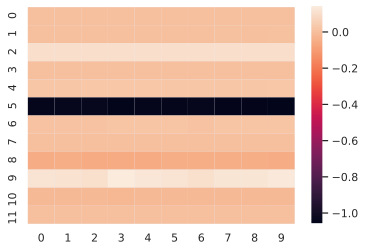

In [35]:
prediction, dt, theta = library(f, x)
theta_normed = theta / jnp.linalg.norm(theta, axis=1, keepdims=True)
fit = lambda X, y: jnp.linalg.lstsq(X, y)[0]
coeffs = jax.vmap(fit, in_axes=(0, 0), out_axes=0)(theta, dt)
coeffs_normed = jax.vmap(fit, in_axes=(0, 0), out_axes=0)(theta_normed, dt)
sns.heatmap(coeffs.T.squeeze())

<AxesSubplot:>

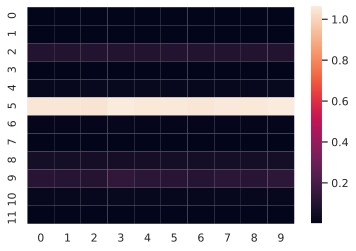

In [36]:
sns.heatmap(jnp.abs(coeffs.T.squeeze()))

<AxesSubplot:>

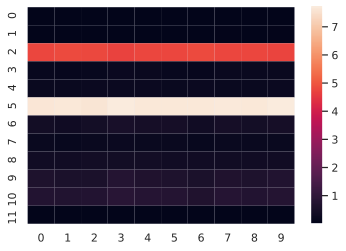

In [37]:
sns.heatmap(jnp.abs(coeffs_normed.T.squeeze()))

# Multitask network

Now let's try the same trick with the multitask network

In [38]:
# Instantiating model and optimizers
model = MultiTaskMLP([30, 30], [30, 30, 1], n_out)
key = random.PRNGKey(42)
params = model.init(key, X_train[[0], :])
optimizer = optim.Adam(learning_rate=2e-3, beta1=0.99, beta2=0.99)
optimizer = optimizer.create(params)

In [44]:
def train_step(model, x, y):
    """Constructs a fast update given a loss function.
    """

    def step(opt, x, y, model):
        def loss_fn(params):
            prediction = model.apply(params, x)
            loss = mse_loss(prediction.squeeze().T, y)

            return loss

        grad_fn = jax.value_and_grad(loss_fn)
        loss, grad = grad_fn(opt.target)
        opt = opt.apply_gradient(grad)  # Return the updated optimizer with parameters.
        return opt, loss

    return jax.jit(lambda opt: step(opt, x, y, model))

In [45]:
%%time
# Compiling train step
step = train_step(model, X_train, y_train)
_ = step(optimizer)  # triggering compilation

CPU times: user 652 ms, sys: 60.2 ms, total: 712 ms
Wall time: 1 s


In [46]:
%%time
# Running to convergence
max_epochs = 10001
for i in jnp.arange(max_epochs):
    optimizer, loss = step(optimizer)
    if i % 1000 == 0:
        print(f"Loss step {i}: {loss}")

Loss step 0: 0.2823191285133362
Loss step 1000: 4.222310599288903e-05
Loss step 2000: 2.254723085570731e-06
Loss step 3000: 1.481249569224019e-06
Loss step 4000: 1.2056271998517332e-06
Loss step 5000: 1.1974909739365103e-06
Loss step 6000: 9.86257873591967e-07
Loss step 7000: 7.404560165014118e-07
Loss step 8000: 9.118322168433224e-07
Loss step 9000: 8.167896226041194e-07
Loss step 10000: 1.1190311397513142e-06
CPU times: user 6.44 s, sys: 212 ms, total: 6.65 s
Wall time: 6.27 s


In [49]:
f(X_train)

(2000, 10)

In [52]:
prediction, dt, theta = library(f, X_train)

In [53]:
theta.shape

(10, 2000, 12)

In [4]:
# Instantiating model and optimizers
model = MultiTaskMLP([30, 30], [30, 30, 1], n_out)
key = random.PRNGKey(42)
params = model.init(key, X_train[[0], :])
optimizer = optim.Adam(learning_rate=2e-3, beta1=0.99, beta2=0.99)
optimizer = optimizer.create(params)

In [12]:
def train_step_pinn(model, library, x, y):
    """Constructs a fast update given a loss function.
    """
    def step(opt, x, y, model, library):
        def loss_fn(params, x, y, model, library):
            f = lambda x: model.apply(params, x).squeeze().T
            prediction, dt, theta = library(f, x)
            
            fit = lambda X, y: jnp.linalg.lstsq(X, y)[0]
            coeffs = jax.vmap(fit, in_axes=(0, 0), out_axes=0)(theta, dt) #vmap over experiments
            
            loss = mse_loss(prediction, y) + mse_loss(dt.squeeze(), (theta @ coeffs).squeeze())
            return loss

        grad_fn = jax.value_and_grad(loss_fn, argnums=0)
        loss, grad = grad_fn(opt.target, x, y, model, library)
        opt = opt.apply_gradient(grad)  # Return the updated optimizer with parameters.
        return opt, loss
    return jax.jit(partial(step, x=x, y=y, model=model, library=library))

In [13]:
%%time
# Compiling train step
step = train_step_pinn(model, library, X_train, y_train)
_ = step(optimizer)  # triggering compilation

CPU times: user 2.5 s, sys: 15.1 ms, total: 2.52 s
Wall time: 2.95 s


In [14]:
%%time
# Running to convergence
max_epochs = 10001
for i in jnp.arange(max_epochs):
    optimizer, loss = step(optimizer)
    if i % 1000 == 0:
        print(f"Loss step {i}: {loss}")

Loss step 0: 0.289483904838562
Loss step 1000: 0.0006163085345178843
Loss step 2000: 4.32298838859424e-05
Loss step 3000: 1.7549811673234217e-05
Loss step 4000: 1.1218646250199527e-05
Loss step 5000: 7.763185749354307e-06
Loss step 6000: 6.965483407839201e-06
Loss step 7000: 7.857630407670513e-06
Loss step 8000: 5.136641448189039e-06
Loss step 9000: 5.162467459740583e-06
Loss step 10000: 5.783648703072686e-06
CPU times: user 2min 38s, sys: 523 ms, total: 2min 39s
Wall time: 2min 37s
